/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


> Average Accuracy across 5-folds: 94.90% (+/- 0.63%)


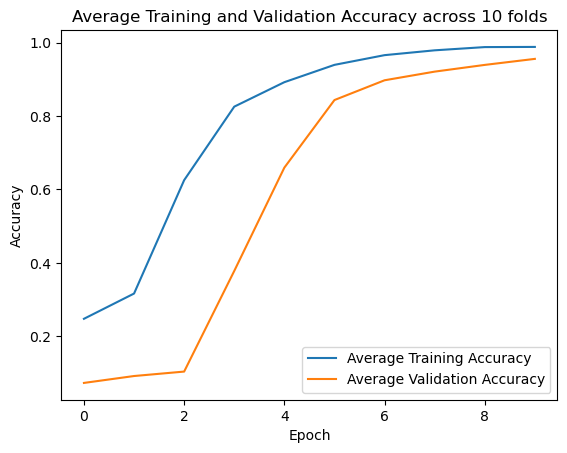

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


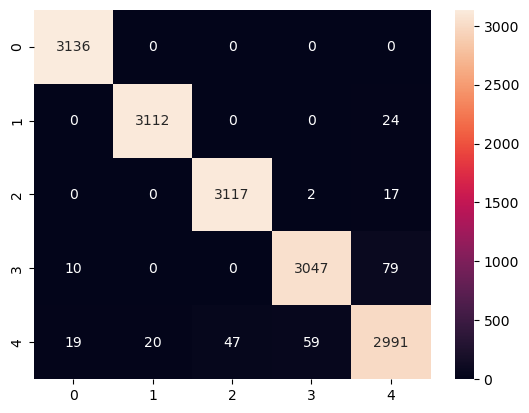

                                                     precision    recall  f1-score   support

          Navigation and Interaction Problems (NAV)       0.99      1.00      1.00      3136
                   Input and Control Issues (INPUT)       0.99      0.99      0.99      3136
    Compatibility with Assistive Technologies (CAT)       0.99      0.99      0.99      3136
                       UI Accessibility Issues (UI)       0.98      0.97      0.98      3136
Audio and Visual Accessibility issues (AUDIOVISUAL)       0.96      0.95      0.96      3136

                                           accuracy                           0.98     15680
                                          macro avg       0.98      0.98      0.98     15680
                                       weighted avg       0.98      0.98      0.98     15680



In [1]:
#GRU Model For sarcasm Annotated dataset...............



import pandas as pd
import numpy as np
import re
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.text import Tokenizer  # Updated import
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Updated import
from tensorflow.keras.models import Sequential  # Updated import
from tensorflow.keras.layers import Embedding, GRU, Dropout, Dense  # Updated import
from tensorflow.keras.optimizers import Adam  # Updated import
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler


# 1. Load and Preprocess the dataset
#df = pd.read_csv('Amazon_Dataset_LD.csv', encoding='latin1')
df = pd.read_csv('accessibilityissues_multi.csv', encoding='latin1')
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

df['Review'] = df['Review'].apply(clean_text)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Review'])
X = tokenizer.texts_to_sequences(df['Review'])
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
X = pad_sequences(X, padding='post', maxlen=maxlen)
y_dict = {'Navigation and Interaction Problems (NAV)': 0, 'Input and Control Issues (INPUT)': 1, 'Compatibility with Assistive Technologies (CAT)': 2, 'UI Accessibility Issues (UI)': 3, 'Audio and Visual Accessibility issues (AUDIOVISUAL)': 4}
y = df['Assessability Issue Type'].map(y_dict)
y = pd.get_dummies(df['Assessability Issue Type']).values

# 2. Oversample to balance classes
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# 3. Define the GRU model
def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))
    model.add(GRU(64))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 4. K-Fold Cross-Validation
n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True)
fold_no = 1
acc_per_fold = []

# Lists to store average accuracies across folds
avg_train_acc = []
avg_val_acc = []

for train, test in kfold.split(X_resampled, y_resampled):
    model = create_model()
    history = model.fit(X_resampled[train], y_resampled[train], validation_split=0.1, epochs=10, batch_size=32, verbose=0)
    
    avg_train_acc.append(history.history['accuracy'])
    avg_val_acc.append(history.history['val_accuracy'])

    scores = model.evaluate(X_resampled[test], y_resampled[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    fold_no += 1

# 5. Performance Metrics
print(f'> Average Accuracy across {n_folds}-folds: {np.mean(acc_per_fold):.2f}% (+/- {np.std(acc_per_fold):.2f}%)')

# Average Training and Validation Accuracy for 5 folds
plt.plot(np.mean(avg_train_acc, axis=0), label='Average Training Accuracy')
plt.plot(np.mean(avg_val_acc, axis=0), label='Average Validation Accuracy')
plt.title('Average Training and Validation Accuracy across 10 folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion Matrix
y_pred = model.predict(X_resampled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_resampled, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()

# Classification Report
print(classification_report(y_true_classes, y_pred_classes, target_names=list(y_dict.keys())))


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


> Average Accuracy across 10-folds: 96.25% (+/- 0.58%)


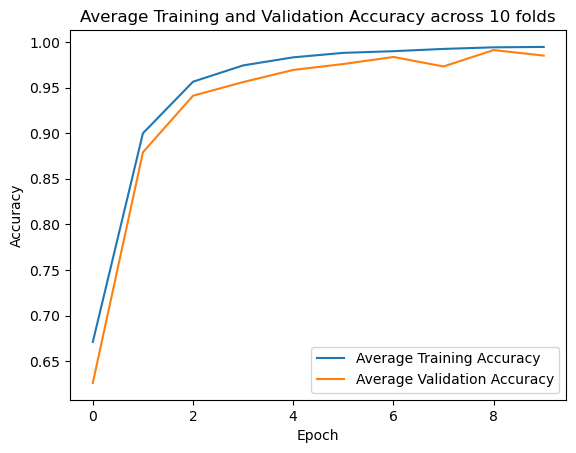

490/490 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step


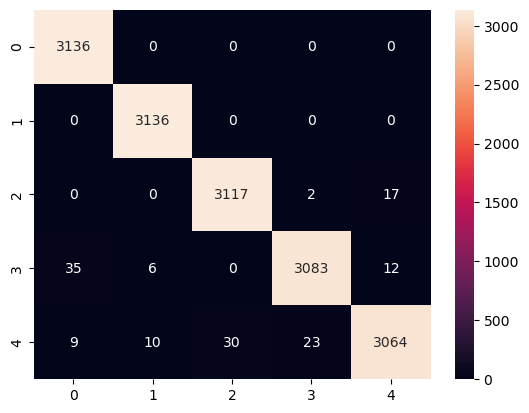

                                                     precision    recall  f1-score   support

          Navigation and Interaction Problems (NAV)       0.99      1.00      0.99      3136
                   Input and Control Issues (INPUT)       0.99      1.00      1.00      3136
    Compatibility with Assistive Technologies (CAT)       0.99      0.99      0.99      3136
                       UI Accessibility Issues (UI)       0.99      0.98      0.99      3136
Audio and Visual Accessibility issues (AUDIOVISUAL)       0.99      0.98      0.98      3136

                                           accuracy                           0.99     15680
                                          macro avg       0.99      0.99      0.99     15680
                                       weighted avg       0.99      0.99      0.99     15680



In [3]:
# BiGRU Model For Sarcasm Annotated Dataset

import pandas as pd
import numpy as np
import re
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
# 1. Load and Preprocess the dataset
#df = pd.read_csv('Amazon_Dataset_LD.csv', encoding='latin1')
df = pd.read_csv('accessibilityissues_multi.csv', encoding='latin1')
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

df['Review'] = df['Review'].apply(clean_text)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Review'])
X = tokenizer.texts_to_sequences(df['Review'])
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
X = pad_sequences(X, padding='post', maxlen=maxlen)
y_dict = {'Navigation and Interaction Problems (NAV)': 0, 'Input and Control Issues (INPUT)': 1, 'Compatibility with Assistive Technologies (CAT)': 2, 'UI Accessibility Issues (UI)': 3, 'Audio and Visual Accessibility issues (AUDIOVISUAL)': 4}
y = df['Assessability Issue Type'].map(y_dict)
y = pd.get_dummies(df['Assessability Issue Type']).values

# 2. Oversample to balance classes
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# 3. Define the BiGRU model
def create_bigru_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))
    model.add(Bidirectional(GRU(64, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(GRU(64)))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 4. K-Fold Cross-Validation
n_folds = 10
kfold = KFold(n_splits=n_folds, shuffle=True)
fold_no = 1
acc_per_fold = []

# Lists to store average accuracies across folds
avg_train_acc = []
avg_val_acc = []

for train, test in kfold.split(X_resampled, y_resampled):
    model = create_bigru_model()
    history = model.fit(X_resampled[train], y_resampled[train], validation_split=0.1, epochs=10, batch_size=32, verbose=0)
    
    avg_train_acc.append(history.history['accuracy'])
    avg_val_acc.append(history.history['val_accuracy'])

    scores = model.evaluate(X_resampled[test], y_resampled[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    fold_no += 1

# 5. Performance Metrics
print(f'> Average Accuracy across {n_folds}-folds: {np.mean(acc_per_fold):.2f}% (+/- {np.std(acc_per_fold):.2f}%)')

# Average Training and Validation Accuracy for 5 folds
plt.plot(np.mean(avg_train_acc, axis=0), label='Average Training Accuracy')
plt.plot(np.mean(avg_val_acc, axis=0), label='Average Validation Accuracy')
plt.title('Average Training and Validation Accuracy across 10 folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion Matrix
y_pred = model.predict(X_resampled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_resampled, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()

# Classification Report
print(classification_report(y_true_classes, y_pred_classes, target_names=list(y_dict.keys())))


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


> Average Accuracy across 10-folds: 97.61% (+/- 0.34%)


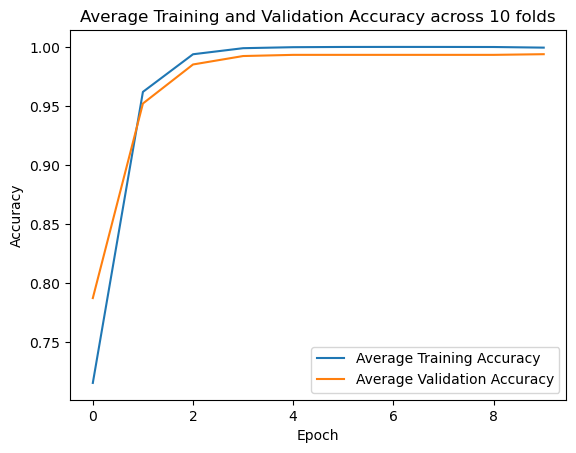

490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


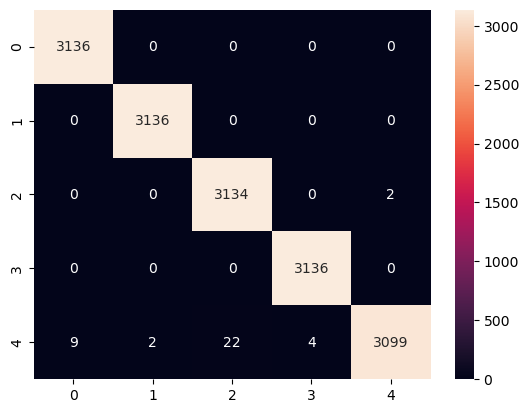

                                                     precision    recall  f1-score   support

          Navigation and Interaction Problems (NAV)       1.00      1.00      1.00      3136
                   Input and Control Issues (INPUT)       1.00      1.00      1.00      3136
    Compatibility with Assistive Technologies (CAT)       0.99      1.00      1.00      3136
                       UI Accessibility Issues (UI)       1.00      1.00      1.00      3136
Audio and Visual Accessibility issues (AUDIOVISUAL)       1.00      0.99      0.99      3136

                                           accuracy                           1.00     15680
                                          macro avg       1.00      1.00      1.00     15680
                                       weighted avg       1.00      1.00      1.00     15680



In [7]:

#CNN  Dataset , Oversampling , 


import pandas as pd
import numpy as np
import re
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.text import Tokenizer  # Updated import
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Updated import
from tensorflow.keras.models import Sequential  # Updated import
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dropout, Dense  # Updated import
from tensorflow.keras.optimizers import Adam  # Updated import
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler



# 3. Define the CNN model
def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 4. K-Fold Cross-Validation
n_folds = 10
kfold = KFold(n_splits=n_folds, shuffle=True)
fold_no = 1
acc_per_fold = []

# Lists to store average accuracies across folds
avg_train_acc = []
avg_val_acc = []

for train, test in kfold.split(X_resampled, y_resampled):
    model = create_model()
    history = model.fit(X_resampled[train], y_resampled[train], validation_split=0.1, epochs=10, batch_size=32, verbose=0)
    
    avg_train_acc.append(history.history['accuracy'])
    avg_val_acc.append(history.history['val_accuracy'])

    scores = model.evaluate(X_resampled[test], y_resampled[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    fold_no += 1

# 5. Performance Metrics
print(f'> Average Accuracy across {n_folds}-folds: {np.mean(acc_per_fold):.2f}% (+/- {np.std(acc_per_fold):.2f}%)')

# Average Training and Validation Accuracy for 5 folds
plt.plot(np.mean(avg_train_acc, axis=0), label='Average Training Accuracy')
plt.plot(np.mean(avg_val_acc, axis=0), label='Average Validation Accuracy')
plt.title('Average Training and Validation Accuracy across 10 folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion Matrix
y_pred = model.predict(X_resampled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_resampled, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()

# Classification Report
print(classification_report(y_true_classes, y_pred_classes, target_names=list(y_dict.keys())))



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


> Average Accuracy across 5-folds: 45.84% (+/- 4.51%)


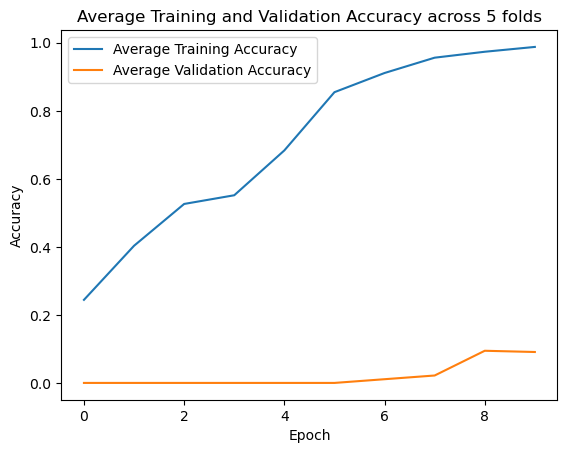

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


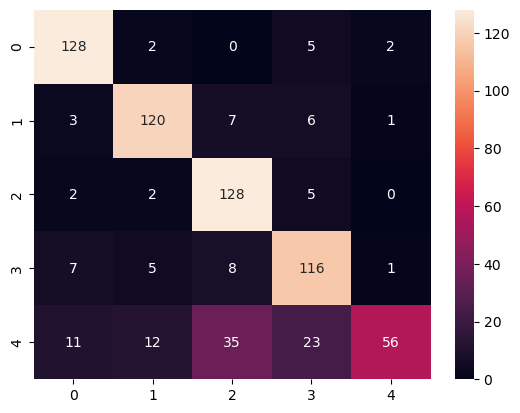

                                                     precision    recall  f1-score   support

          Navigation and Interaction Problems (NAV)       0.85      0.93      0.89       137
                   Input and Control Issues (INPUT)       0.85      0.88      0.86       137
    Compatibility with Assistive Technologies (CAT)       0.72      0.93      0.81       137
                       UI Accessibility Issues (UI)       0.75      0.85      0.79       137
Audio and Visual Accessibility issues (AUDIOVISUAL)       0.93      0.41      0.57       137

                                           accuracy                           0.80       685
                                          macro avg       0.82      0.80      0.79       685
                                       weighted avg       0.82      0.80      0.79       685



In [17]:
#CNN manual annoated dataset dataset, undersampling

import pandas as pd
import numpy as np
import re
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.text import Tokenizer  # Updated import
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Updated import
from tensorflow.keras.models import Sequential  # Updated import
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dropout, Dense  # Updated import
from tensorflow.keras.optimizers import Adam  # Updated import
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler


# 2. Undersample to balance classes
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# 3. Define the CNN model
def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 4. K-Fold Cross-Validation
n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True)
fold_no = 1
acc_per_fold = []

# Lists to store average accuracies across folds
avg_train_acc = []
avg_val_acc = []

for train, test in kfold.split(X_resampled, y_resampled):
    model = create_model()
    history = model.fit(X_resampled[train], y_resampled[train], validation_split=0.1, epochs=10, batch_size=32, verbose=0)
    
    avg_train_acc.append(history.history['accuracy'])
    avg_val_acc.append(history.history['val_accuracy'])

    scores = model.evaluate(X_resampled[test], y_resampled[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    fold_no += 1

# 5. Performance Metrics
print(f'> Average Accuracy across {n_folds}-folds: {np.mean(acc_per_fold):.2f}% (+/- {np.std(acc_per_fold):.2f}%)')

# Average Training and Validation Accuracy for 5 folds
plt.plot(np.mean(avg_train_acc, axis=0), label='Average Training Accuracy')
plt.plot(np.mean(avg_val_acc, axis=0), label='Average Validation Accuracy')
plt.title('Average Training and Validation Accuracy across 5 folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion Matrix
y_pred = model.predict(X_resampled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_resampled, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()

# Classification Report
print(classification_report(y_true_classes, y_pred_classes, target_names=list(y_dict.keys())))









/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


> Average Accuracy across 5-folds: 96.88% (+/- 0.08%)


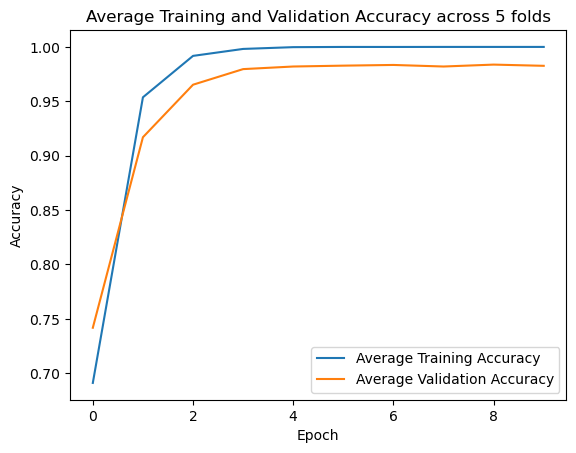

490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [23]:
import pandas as pd
import numpy as np
import re
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import label_binarize  # Correct import
from sklearn.metrics import roc_curve, auc


# 2. Oversample to balance classes
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# 3. Define the CNN model
def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 4. K-Fold Cross-Validation
n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True)
fold_no = 1
acc_per_fold = []

# Lists to store average accuracies across folds
avg_train_acc = []
avg_val_acc = []

for train, test in kfold.split(X_resampled, y_resampled):
    model = create_model()
    history = model.fit(X_resampled[train], y_resampled[train], validation_split=0.1, epochs=10, batch_size=32, verbose=0)
    
    avg_train_acc.append(history.history['accuracy'])
    avg_val_acc.append(history.history['val_accuracy'])

    scores = model.evaluate(X_resampled[test], y_resampled[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    fold_no += 1

# 5. Performance Metrics
print(f'> Average Accuracy across {n_folds}-folds: {np.mean(acc_per_fold):.2f}% (+/- {np.std(acc_per_fold):.2f}%)')

# Average Training and Validation Accuracy for 5 folds
plt.plot(np.mean(avg_train_acc, axis=0), label='Average Training Accuracy')
plt.plot(np.mean(avg_val_acc, axis=0), label='Average Validation Accuracy')
plt.title('Average Training and Validation Accuracy across 5 folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 6. ROC curve
y_pred = model.predict(X_resampled)
y_true_classes = np.argmax(y_resampled, axis=1)
y_pred_probs = model.predict(X_resampled)

# Binarize the true labels for ROC
y_true_binarized = label_binarize(y_true_classes, classes=[0, 1, 2, 3, 4, 5, 6, 7])

# Initialize variables to store fpr, tpr, and auc for each class
fpr = dict()
tpr = dict()
roc_auc = dict()




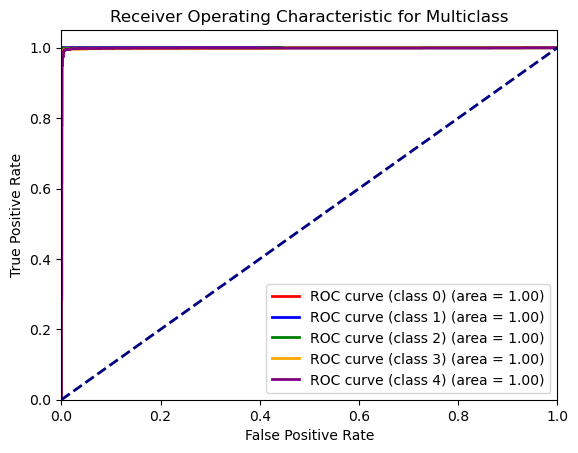

In [25]:
# Calculate ROC curve and AUC for each class
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure()
colors = ['red', 'blue', 'green', 'orange', 'purple']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multiclass')
plt.legend(loc='lower right')
plt.show()



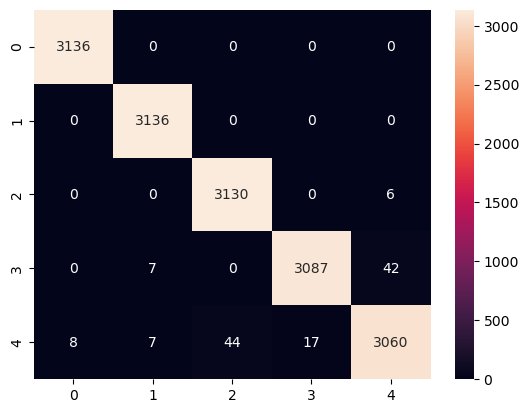

In [27]:
# 7. Confusion Matrix
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()


In [29]:

# 8. Classification Report
print(classification_report(y_true_classes, y_pred_classes, target_names=list(y_dict.keys())))

                                                     precision    recall  f1-score   support

          Navigation and Interaction Problems (NAV)       1.00      1.00      1.00      3136
                   Input and Control Issues (INPUT)       1.00      1.00      1.00      3136
    Compatibility with Assistive Technologies (CAT)       0.99      1.00      0.99      3136
                       UI Accessibility Issues (UI)       0.99      0.98      0.99      3136
Audio and Visual Accessibility issues (AUDIOVISUAL)       0.98      0.98      0.98      3136

                                           accuracy                           0.99     15680
                                          macro avg       0.99      0.99      0.99     15680
                                       weighted avg       0.99      0.99      0.99     15680

